In [1]:
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(Image.open("../../CLIP/CLIP.png")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[0.99279356 0.00421071 0.00299577]]


In [2]:
path = "../datasets/ILSVRC2012/validation/n02128757/n02128757_ILSVRC2012_val_00005277.JPEG"

In [3]:
image = preprocess(Image.open(path)).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat", "a leopard", "a snow leopard"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[2.1263211e-06 8.7296263e-05 1.4175400e-03 3.2917034e-02 9.6557605e-01]]


In [4]:
image_features.shape

torch.Size([1, 512])

In [3]:
import torch
import numpy as np
import pickle
import time
# import matplotlib.pyplot as plt
from PIL import Image


def center_crop_arr(pil_image, image_size):
    # We are not on a new enough PIL to support the `reducing_gap`
    # argument, which uses BOX downsampling at powers of two first.
    # Thus, we do it by hand to improve downsample quality.
    while min(*pil_image.size) >= 2 * image_size:
        pil_image = pil_image.resize(
            tuple(x // 2 for x in pil_image.size), resample=Image.BOX
        )

    scale = image_size / min(*pil_image.size)
    pil_image = pil_image.resize(
        tuple(round(x * scale) for x in pil_image.size), resample=Image.BICUBIC
    )

    arr = np.array(pil_image)
    crop_y = (arr.shape[0] - image_size) // 2
    crop_x = (arr.shape[1] - image_size) // 2
    return arr[crop_y : crop_y + image_size, crop_x : crop_x + image_size]


def load_image(path, crop=False):
    img = Image.open(path)
    img = img.convert('RGB')
    if crop:
        img = center_crop_arr(img, 256)
    img = np.array(img)
    img = img.transpose(2, 0, 1)
    img = img / 255
    return img

In [6]:
image = preprocess(Image.open(path)).unsqueeze(0).to(device)
type(image), image.shape, image.dtype

(torch.Tensor, torch.Size([1, 3, 224, 224]), torch.float32)

In [5]:
import torch
from PIL import Image

# Assuming preprocess and model are already defined
# image = preprocess(Image.open(path)).unsqueeze(0).to(device)
image = load_image(path, crop=True) * 255
image = image.transpose(1,2,0).astype(np.uint8) 
# print(image.shape), print(type(image))
image = Image.fromarray(image)

image = preprocess(image).unsqueeze(0).to(device)
print(image.shape)

# Hook to get intermediate transformer outputs
dict_activation = {}
# def get_intermediate_features(module, input, output):
#     dict_activation[module] = output
#     return output
def get_activation(name):
    def hook(model, input, output):
        dict_activation[name] = output.detach()
    return hook

target_modules = ['transformer', 'conv1'] + ['transformer.resblocks.'+str(i) for i in range(12)] + ['ln_post']

# Register a hook on the transformer to get token-wise embeddings
# handle = model.visual.transformer.register_forward_hook(get_intermediate_features)
for name, module in model.visual.named_modules():
    if name in target_modules:
        module.register_forward_hook(get_activation(name))



# Pass the image through the model
with torch.no_grad():
    image_features = model.encode_image(image)

# # Access the token-wise features
# # Assuming you want the output from the specific layer you registered the hook on
# token_features = list(dict_activation.values())[0]  # This will be the sequence of token embeddings

# # Don't forget to remove the hook when done
# handle.remove()

# # Now you can use token_features as needed
# print(token_features.shape)

# Print the activations
print('Image features:', image_features.shape)
for name, activation in dict_activation.items():
    print(f'{name}: {activation.shape}')

torch.Size([1, 3, 224, 224])
Image features: torch.Size([1, 512])
conv1: torch.Size([1, 768, 7, 7])
transformer.resblocks.0: torch.Size([50, 1, 768])
transformer.resblocks.1: torch.Size([50, 1, 768])
transformer.resblocks.2: torch.Size([50, 1, 768])
transformer.resblocks.3: torch.Size([50, 1, 768])
transformer.resblocks.4: torch.Size([50, 1, 768])
transformer.resblocks.5: torch.Size([50, 1, 768])
transformer.resblocks.6: torch.Size([50, 1, 768])
transformer.resblocks.7: torch.Size([50, 1, 768])
transformer.resblocks.8: torch.Size([50, 1, 768])
transformer.resblocks.9: torch.Size([50, 1, 768])
transformer.resblocks.10: torch.Size([50, 1, 768])
transformer.resblocks.11: torch.Size([50, 1, 768])
transformer: torch.Size([50, 1, 768])
ln_post: torch.Size([1, 768])


In [7]:
tt = torch.tensor([[1,2], [3,4]])
print(tt)
flat = tt.reshape(-1)
print(flat)
print(flat.reshape(2,2))

tensor([[1, 2],
        [3, 4]])
tensor([1, 2, 3, 4])
tensor([[1, 2],
        [3, 4]])


In [22]:
for key in dict_activation.keys():
    print(key)

for val in dict_activation.values():
    print(val.shape)

Transformer(
  (resblocks): Sequential(
    (0): ResidualAttentionBlock(
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (c_fc): Linear(in_features=768, out_features=3072, bias=True)
        (gelu): QuickGELU()
        (c_proj): Linear(in_features=3072, out_features=768, bias=True)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (1): ResidualAttentionBlock(
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (c_fc): Linear(in_features=768, out_features=3072, bias=True)
        (gelu): QuickGELU()
        (c_proj): Linear(in_features=3072, out_features=768, bias=True)
      

(256, 256, 3)
<class 'numpy.ndarray'>


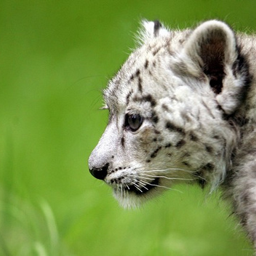

In [6]:
image = load_image(path, crop=True) * 255
image = image.transpose(1,2,0).astype(np.uint8) 
print(image.shape), print(type(image))
image = Image.fromarray(image)
type(image)
image

torch.Size([1, 3, 224, 224])


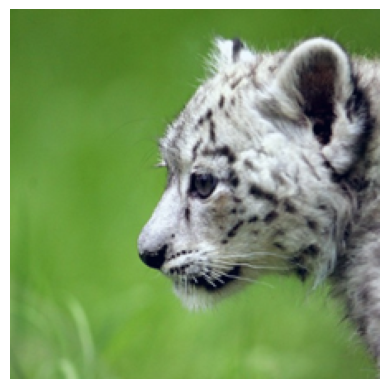

In [33]:
image = load_image(path, crop=True) * 255
image = image.transpose(1,2,0).astype(np.uint8) 
# print(image.shape), print(type(image))
image = Image.fromarray(image)

image = preprocess(image).unsqueeze(0).to(device)
print(image.shape)

im = image[0]
# Normalize the image
im -= im.min()
im /= im.max()
im = im.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots()
ax.imshow(im)
ax.axis('off')
ax.set_aspect('equal')
# fig.tight_layout()
# plt.savefig(f'../../plots/clip-downsized_leo.png', dpi = 400, bbox_inches='tight')
plt.show()

In [60]:
image = load_image(path, crop=True) * 255
image = image.transpose(1,2,0).astype(np.uint8) 
# print(image.shape), print(type(image))
# image = Image.fromarray(image)

image = preprocess(image).unsqueeze(0).to(device)

TypeError: Unexpected type <class 'numpy.ndarray'>

torch.Size([1, 3, 224, 224])


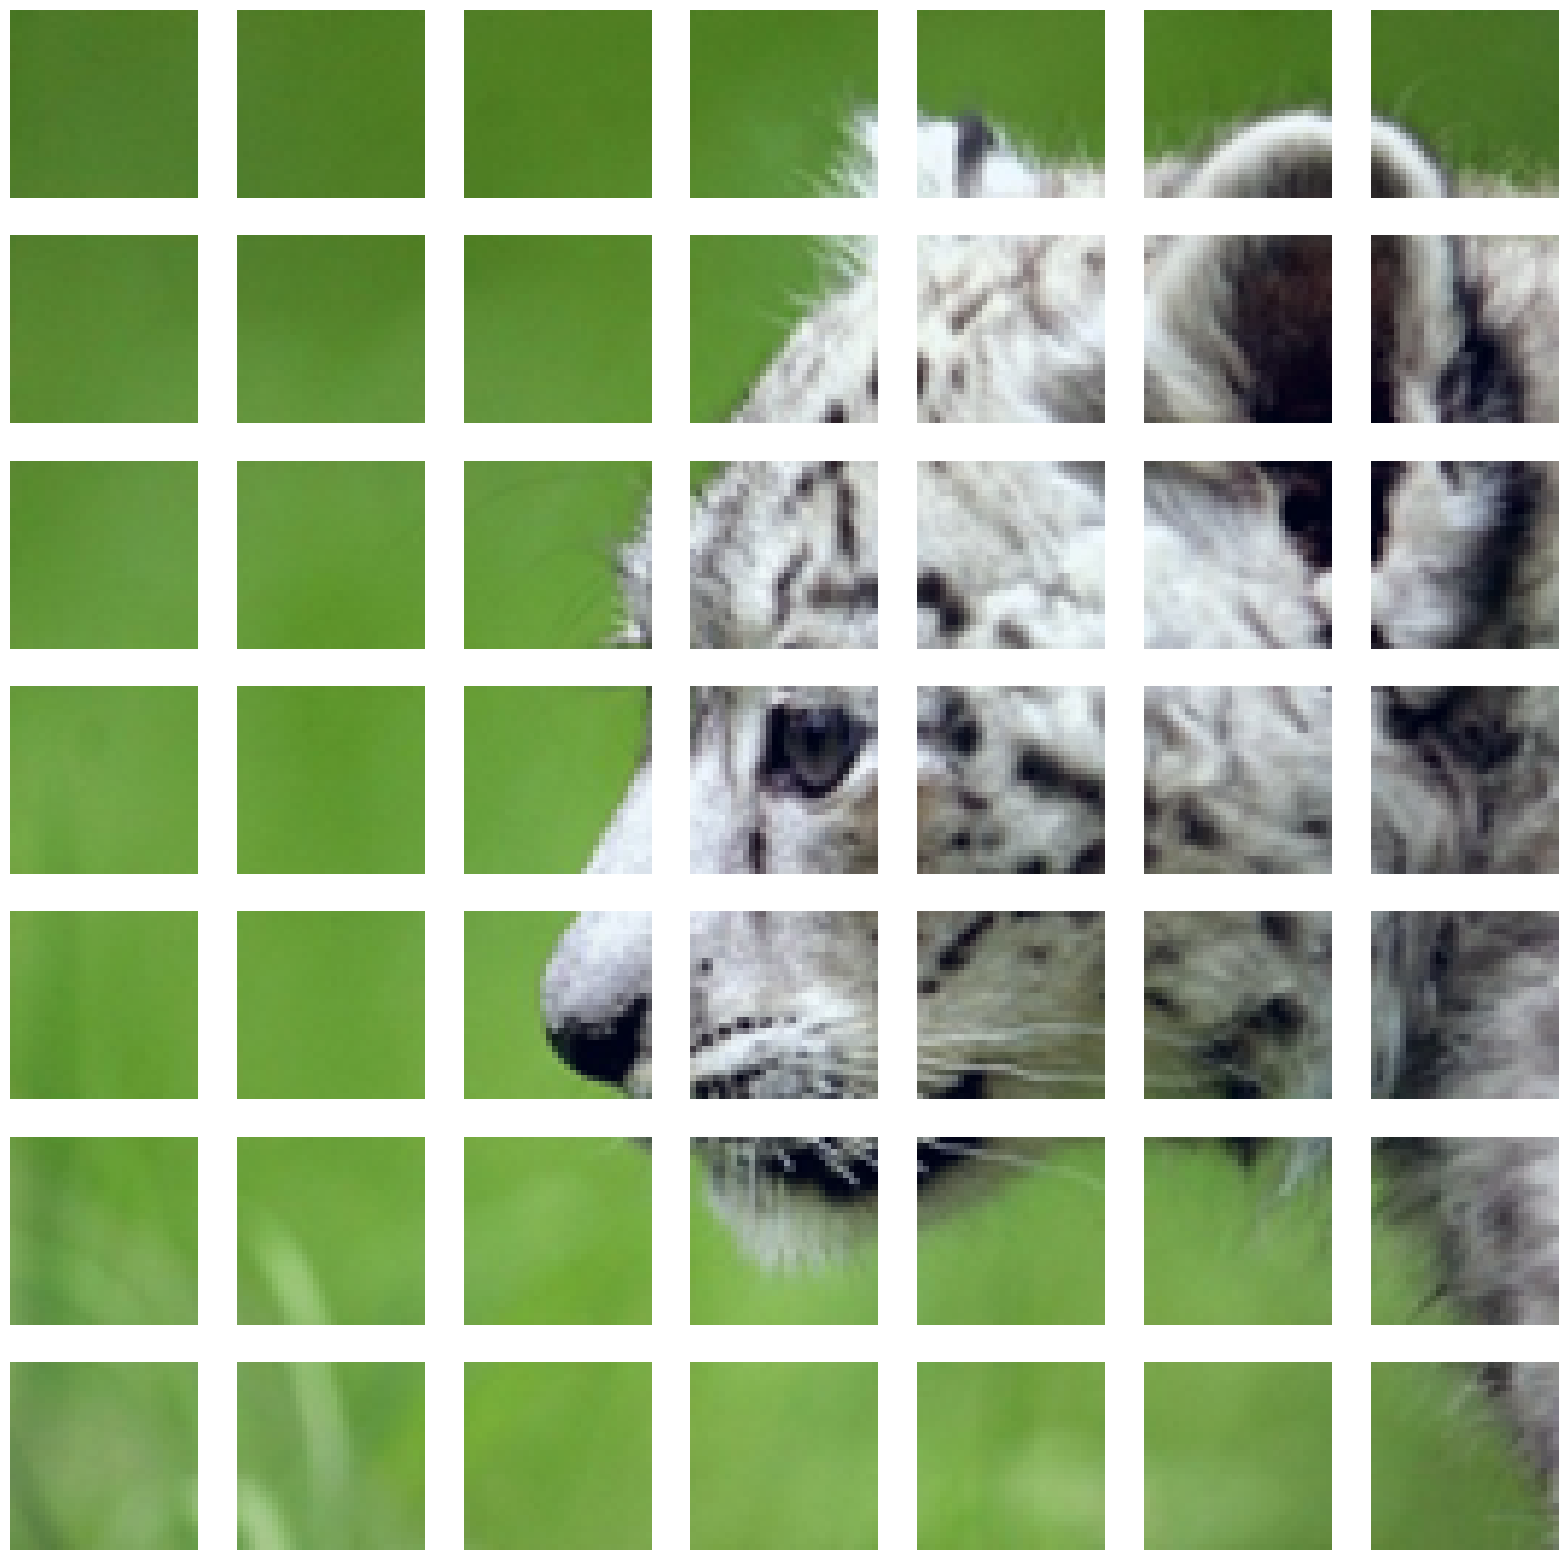

In [31]:
image = load_image(path, crop=True) * 255
image = image.transpose(1,2,0).astype(np.uint8) 
# print(image.shape), print(type(image))
image = Image.fromarray(image)

image = preprocess(image).unsqueeze(0).to(device)
print(image.shape)

im = image[0]
# Normalize the image
im -= im.min()
im /= im.max()
im = im.permute(1,2,0).cpu().numpy()

fig, axs = plt.subplots(7,7, figsize=(20,20))
size = 32

for i in range(7):
    for j in range(7):
        axs[i,j].imshow(im[i*size:(i+1)*size, j*size:(j+1)*size, :])
        axs[i,j].axis('off')
        axs[i,j].set_aspect('equal')
# fig.tight_layout()
# plt.savefig(f'../../plots/clip-tokenized_leo.png', dpi = 400, bbox_inches='tight')
plt.show()

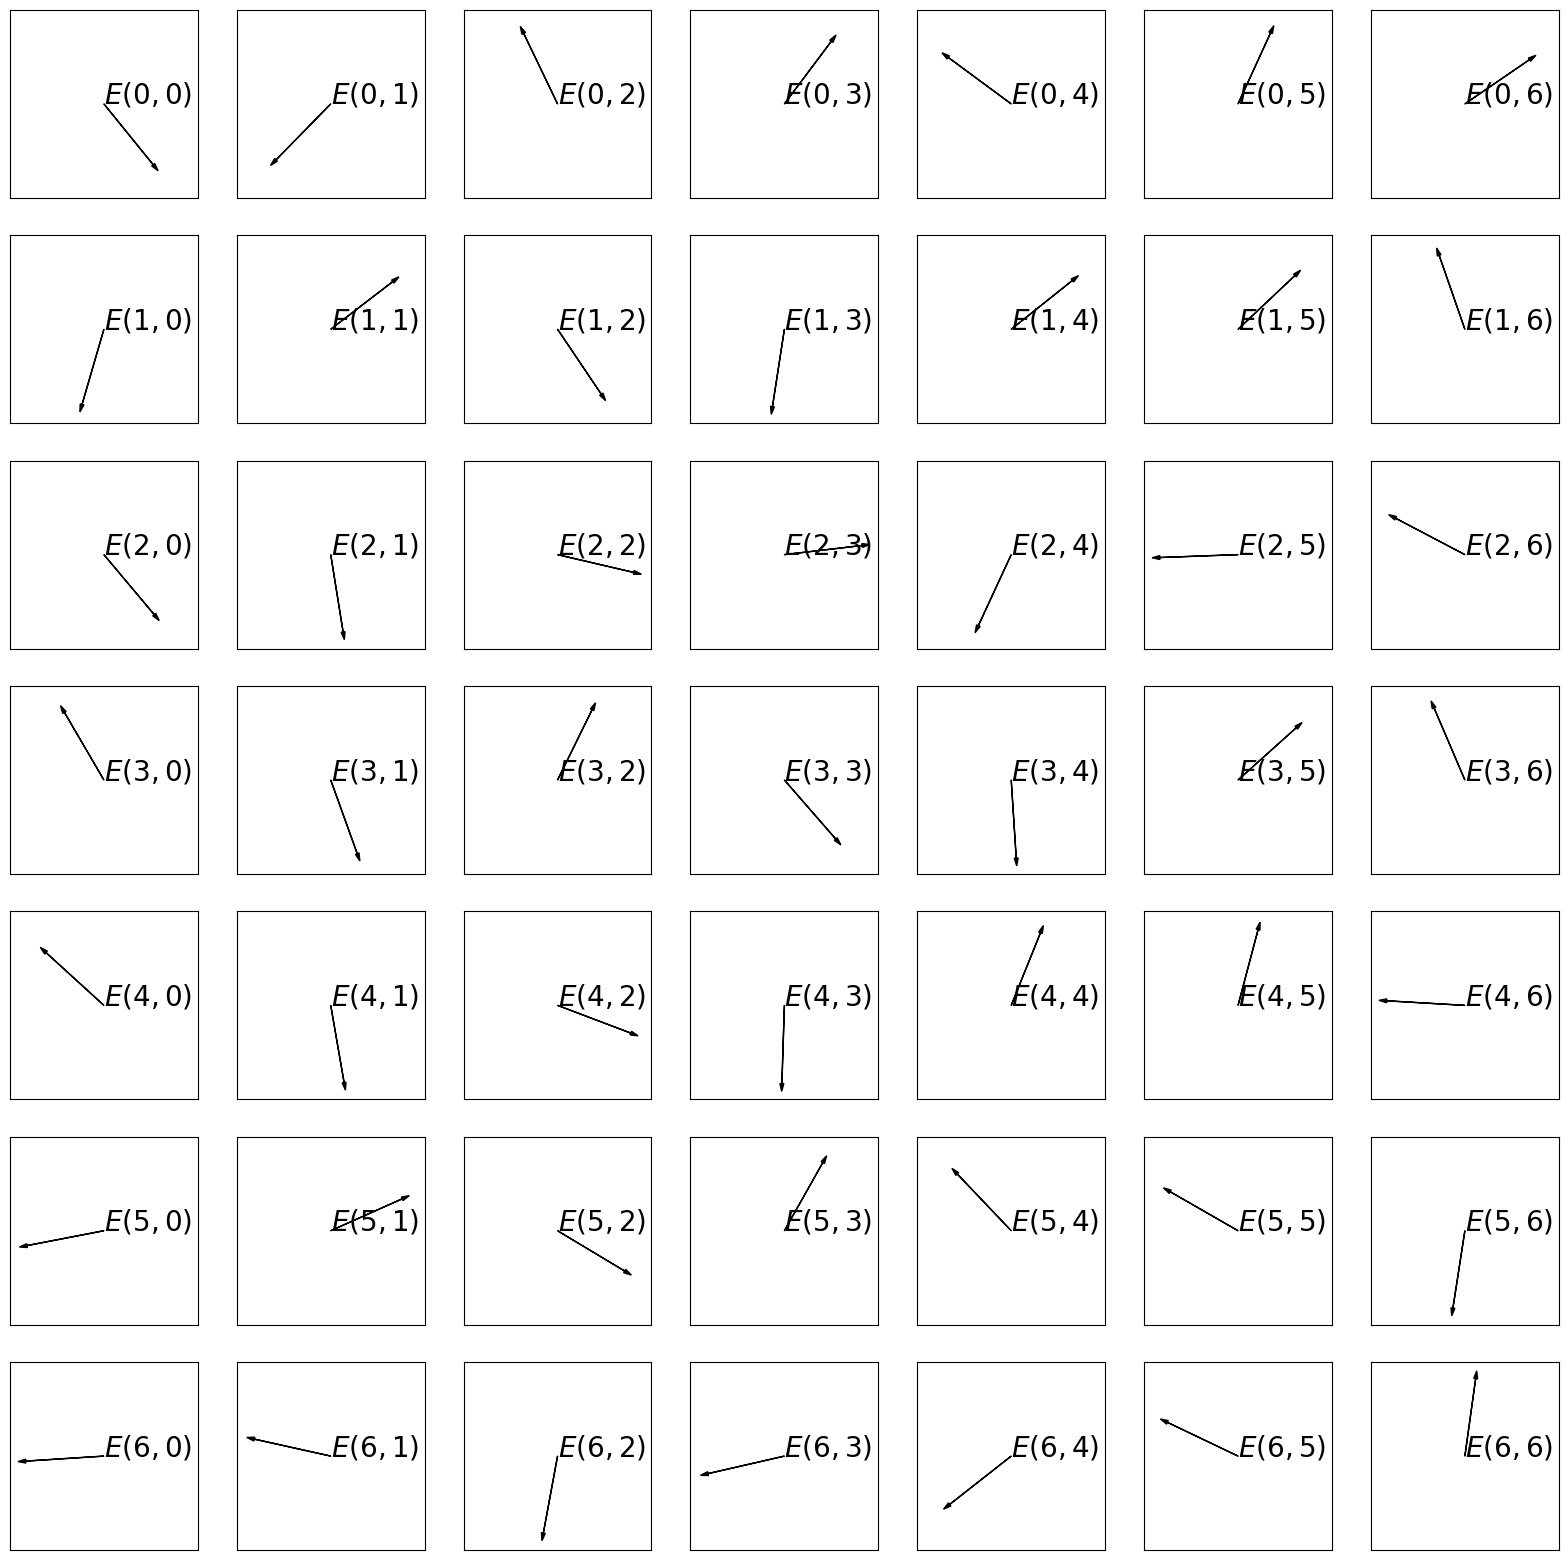

In [51]:
fig, axs = plt.subplots(7,7, figsize=(20,20))

for i in range(7):
    for j in range(7):
        # axs[i,j].imshow(im[i*size:(i+1)*size, j*size:(j+1)*size, :])
        axs[i,j].text(0, 0, f'$E{i,j}$', color='black', fontsize=20, fontweight='bold',)
        arr = np.random.randn(2)
        arr /= np.linalg.norm(arr)
        axs[i,j].arrow(0, 0, arr[0], arr[1], head_width=0.05, head_length=0.1, fc='k', ec='k')
        # axs[i,j].axis('off')
        axs[i,j].set_aspect('equal')
        axs[i,j].set_xlim(-1.2, 1.2)
        axs[i,j].set_ylim(-1.2, 1.2)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
# fig.tight_layout()
# plt.savefig(f'../../plots/clip-embedding.png', dpi = 300, bbox_inches='tight')
plt.show()

In [27]:
im.max(), im.min()

(2.145897, -1.7922626)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)

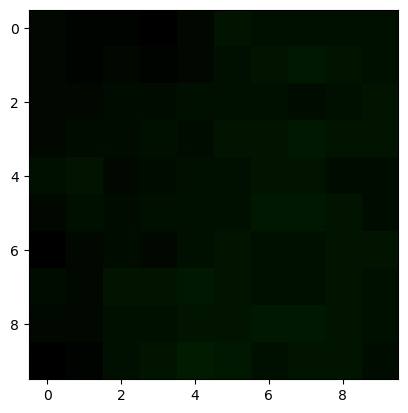

In [19]:
plt.imshow(image[0].permute(1,2,0).cpu().numpy()[:10, :10, :])
image[0].permute(1,2,0).cpu().numpy().shape

In [11]:
im.shape

torch.Size([224, 224, 3])

In [36]:
for name, module in model.visual.named_modules():
    print(name)
    # if name in target_modules:
        # module.register_forward_hook(get_activation(name))

['conv1'] + ['transformer.resblocks.'+str(i) for i in range(12)] + ['ln_post']



conv1
ln_pre
transformer
transformer.resblocks
transformer.resblocks.0
transformer.resblocks.0.attn
transformer.resblocks.0.attn.out_proj
transformer.resblocks.0.ln_1
transformer.resblocks.0.mlp
transformer.resblocks.0.mlp.c_fc
transformer.resblocks.0.mlp.gelu
transformer.resblocks.0.mlp.c_proj
transformer.resblocks.0.ln_2
transformer.resblocks.1
transformer.resblocks.1.attn
transformer.resblocks.1.attn.out_proj
transformer.resblocks.1.ln_1
transformer.resblocks.1.mlp
transformer.resblocks.1.mlp.c_fc
transformer.resblocks.1.mlp.gelu
transformer.resblocks.1.mlp.c_proj
transformer.resblocks.1.ln_2
transformer.resblocks.2
transformer.resblocks.2.attn
transformer.resblocks.2.attn.out_proj
transformer.resblocks.2.ln_1
transformer.resblocks.2.mlp
transformer.resblocks.2.mlp.c_fc
transformer.resblocks.2.mlp.gelu
transformer.resblocks.2.mlp.c_proj
transformer.resblocks.2.ln_2
transformer.resblocks.3
transformer.resblocks.3.attn
transformer.resblocks.3.attn.out_proj
transformer.resblocks.3.ln_

In [29]:
# model.visual.__dir__()
for mod in model.visual.named_modules():
    print(mod)

('', VisionTransformer(
  (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
  (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (transformer): Transformer(
    (resblocks): Sequential(
      (0): ResidualAttentionBlock(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): QuickGELU()
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
      (1): ResidualAttentionBlock(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (ln_1): LayerNorm((768,), eps=1e-05, elemen

In [7]:
dict_activation.keys()

dict_keys([Transformer(
  (resblocks): Sequential(
    (0): ResidualAttentionBlock(
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (c_fc): Linear(in_features=768, out_features=3072, bias=True)
        (gelu): QuickGELU()
        (c_proj): Linear(in_features=3072, out_features=768, bias=True)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (1): ResidualAttentionBlock(
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (c_fc): Linear(in_features=768, out_features=3072, bias=True)
        (gelu): QuickGELU()
        (c_proj): Linear(in_features=3072, out_features=768, bias=T

In [30]:
224/32

7.0

In [15]:
img = Image.open(path)
type(img)

PIL.JpegImagePlugin.JpegImageFile

# Tokens embeddings

In [58]:
def embed(visual, x: torch.Tensor):
    with torch.no_grad():
        x = visual.conv1(x)  # shape = [*, width, grid, grid]
        x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
        x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]
        x = torch.cat([visual.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
        x = x + visual.positional_embedding.to(x.dtype)
        x = visual.ln_pre(x)

        x = x.permute(1, 0, 2)  # NLD -> LND
        x = visual.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD

        class_token = visual.ln_post(x[:, 0, :])

        class_token = class_token @ visual.proj

        x = x[:, 1:, :]
        x = x.reshape(x.shape[0], 7, 7, x.shape[2])

        return x, class_token

toks, glob = embed(model.visual, image)
print(glob.shape, toks.shape)

torch.Size([1, 512]) torch.Size([1, 7, 7, 768])


In [59]:
toks.norm(dim=-1)

tensor([[[19.1790, 18.6265, 17.5901, 17.4965, 16.8546, 18.9125, 18.7796],
         [17.6891, 16.7357, 16.4704, 17.5830, 17.4267, 18.4394, 17.5699],
         [17.0155, 16.3125, 17.6184, 18.6927, 17.6836, 17.6502, 18.4779],
         [17.0567, 16.6632, 18.3043, 16.2750, 20.8461, 18.4886, 17.7907],
         [17.1138, 16.2007, 18.6628, 18.7798, 17.1514, 18.7431, 17.4648],
         [17.3382, 17.8255, 16.3684, 17.2289, 16.5482, 17.0576, 17.0587],
         [17.1643, 17.0094, 17.3886, 16.8517, 18.5700, 16.8794, 16.1721]]])

In [57]:
768**0.5

27.712812921102035

# File analysis

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import time

from collections import defaultdict
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [18]:
def compute_correlation_function(size, C):
    size2 = size*size
    # file = '/scratch/sclocchi/guided-diffusion/correlations_measurements/diffused_ILSVRC2012_validation/correlations_deltaX-t_100_250-magnitude.pk'
    # print("Loading data...", flush=True)
    # with open(args.file, 'rb') as f:
    #     data = pickle.load(f)
    # print("Data loaded.", flush=True)

    # print('Computing correlation matrix...', flush=True)
    # C = data['corr'].reshape(size2, size2) - data['mean'].reshape(size2, 1) @ data['mean'].reshape(1, size2)
    # print('Computed correlation matrix.', flush=True)

    # print('Deleting data...', flush=True)
    # del data
    # print('Deleted data.', flush=True)

    print('Computing indeces...', flush=True)
    idx = torch.triu_indices(size2, size2, offset=0)
    print('Computed indeces.', flush=True)

    print('Computing C values...', flush=True)
    Cvalues = torch.tensor(C[idx[0], idx[1]])
    print('Computed C values.', flush=True)

    # print('Deleting C...', flush=True)
    # del C
    # print('Deleted C.', flush=True)

    print('Computing distances...', flush=True)
    labels = ((idx[1]//size) - (idx[0]//size))**2 
    labels += ((idx[1]%size) - (idx[0]%size))**2
    # file_labels = f'/scratch/sclocchi/guided-diffusion/correlations_measurements/labels_{args.image_size}.pt'
    # lab_dic = torch.load(file_labels)
    # labels = lab_dic['labels']
    # del lab_dic
    # print('Computed distances.', flush=True)

    # if args.unique_labels is not None:
    #     lab_dic = torch.load(f)
    #     unique_labels = lab_dic['labels']
    #     labels_count = lab_dic['labels_count']
    # else:

    print('Computing unique labels...', flush=True)
    time_0 = time.time()
    nested_list = [[i**2 + j**2 for j in range(i+1)] for i in range(size)]
    unique_labels = set([item for sublist in nested_list for item in sublist])
    map_dist_index = {}
    for idx, lab in enumerate(unique_labels):
        map_dist_index[lab] = idx
    # unique_labels, labels_count = labels.unique(dim=0, return_counts=True)
    time_1 = time.time()
    print(f'Computed unique labels. It took {time_1-time_0:.2f} s.', flush=True)

        # file_labels = f'../correlations_measurements/labels_{args.image_size}.pt'
        # torch.save({'labels': unique_labels, 'labels_count': labels_count}, file_labels)


    print('Computing correlation function...', flush=True)
    res = torch.zeros(len(unique_labels), dtype=torch.float)
    labels_count = torch.zeros(len(unique_labels), dtype=torch.int)
    count = 0
    time_0 = time.time()
    print('start loop...', flush=True)

    # for ii in range(len(Cvalues)):
    #     res[map_dist_index[labels[ii].item()]] += Cvalues[ii]
    #     labels_count[map_dist_index[labels[ii].item()]] += 1
    #     count += 1
    #     if count%1000000==0:
    #         print(f'Computed {count}. Time{time.time()-time_0:.2f}', flush=True)

    batch_size = 1000
    for ii in range(len(Cvalues)//batch_size):
        indeces = torch.tensor([map_dist_index[lab.item()] for lab in labels[ii*batch_size:(ii+1)*batch_size]])
        res = res.scatter_add_(0, indeces, Cvalues[ii*batch_size:(ii+1)*batch_size])
        labels_count = labels_count.scatter_add_(0, indeces, torch.ones_like(indeces, dtype=torch.int))

        count += 1
        if count%1000==0:
            print(f'Computed {count}. Time{time.time()-time_0:.2f}', flush=True)
    # res = torch.zeros_like(unique_labels, dtype=torch.float).scatter_add_(0, indeces, Cvalues)

    count *= batch_size
    if count < len(Cvalues):
        indeces = torch.tensor([map_dist_index[lab.item()] for lab in labels[count:]])
        res = res.scatter_add_(0, indeces, Cvalues[count:])
        labels_count = labels_count.scatter_add_(0, indeces, torch.ones_like(indeces, dtype=torch.int))

    res = res / labels_count.float()
    print('Computed correlation function.', flush=True)

    # with open(args.output, 'wb') as f:
    #     pickle.dump({'labels': torch.tensor([dist**0.5 for dist in unique_labels]).cpu().numpy(), 'correlation_function': res.cpu().numpy(), 'susceptibility': Cvalues.sum().cpu().numpy()}, f)

    print('Done.', flush=True)

    return torch.tensor([dist**0.5 for dist in unique_labels]), res, Cvalues.sum()


In [18]:
# key = 'dot_corr'
# key = 'delta_corr'
# keyfun = 'cos_Cfun'
# keydist = 'cos_dist'
# keysus = 'cos_chi'
keyfun = 'deltaMgn_Cfun'
keydist = 'deltaMgn_dist'
keysus = 'deltaMgn_chi'
corrfun_per_time = {}
dist_per_time = {}
susceptibility_per_time = {}
feat_start = {}
feat_sample = {}

for t in range(25, 275, 25):
# for t in [25]:
    # file = f'../Wavelet_coefficients/diffused_ILSVRC2012_validation/wavelet_coeff-t_{t}_250-norm.pk'
    # file = f'../Wavelet_coefficients/diffused_ILSVRC2012_validation/wavelet_coeff-t_{t}_250-complete.pk'
    file = f'../Clip_correlations/diffused_ILSVRC2012_validation/clip_correlation-t_{t}_250.pk'

    with open(file, 'rb') as f:
        data = pickle.load(f)

    # corr = data[key]

    # dist, Cfun, chi = compute_correlation_function(size=7, C=corr.reshape(49, 49))

    # corrfun_per_time[t] = Cfun
    # dist_per_time[t] = dist
    # susceptibility_per_time[t] = chi
    corrfun_per_time[t] = data[keyfun]
    dist_per_time[t] = data[keydist]
    susceptibility_per_time[t] = data[keysus]
    feat_start[t] = data['start_feat']
    feat_sample[t] = data['sample_feat']

    print(f'Computed correlation function at time {t}.')

print(data.keys())

Computed correlation function at time 25.
Computed correlation function at time 50.
Computed correlation function at time 75.
Computed correlation function at time 100.
Computed correlation function at time 125.
Computed correlation function at time 150.
Computed correlation function at time 175.
Computed correlation function at time 200.
Computed correlation function at time 225.
Computed correlation function at time 250.
dict_keys(['start_feat', 'sample_feat', 'dot_corr', 'mean0', 'meant', 'delta_corr', 'mean_delta', 'deltaMgn_corr', 'mean_deltaMgn', 'cos_corr', 'meancos0', 'meancost', 'dot_dist', 'dot_Cfun', 'dot_chi', 'delta_dist', 'delta_Cfun', 'delta_chi', 'deltaMgn_dist', 'deltaMgn_Cfun', 'deltaMgn_chi', 'cos_dist', 'cos_Cfun', 'cos_chi'])


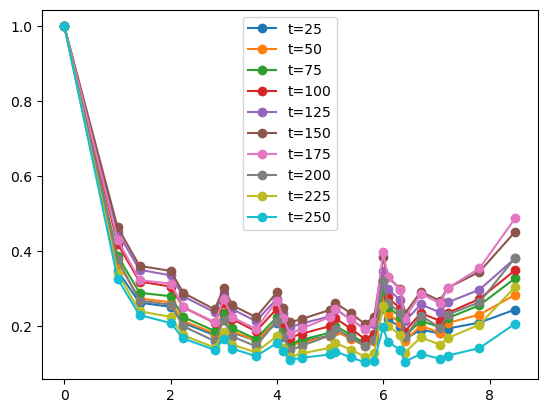

In [15]:
for key in corrfun_per_time.keys():
    plt.plot(dist_per_time[key], corrfun_per_time[key] / corrfun_per_time[key][0], 'o-', label=f't={key}')
plt.legend()

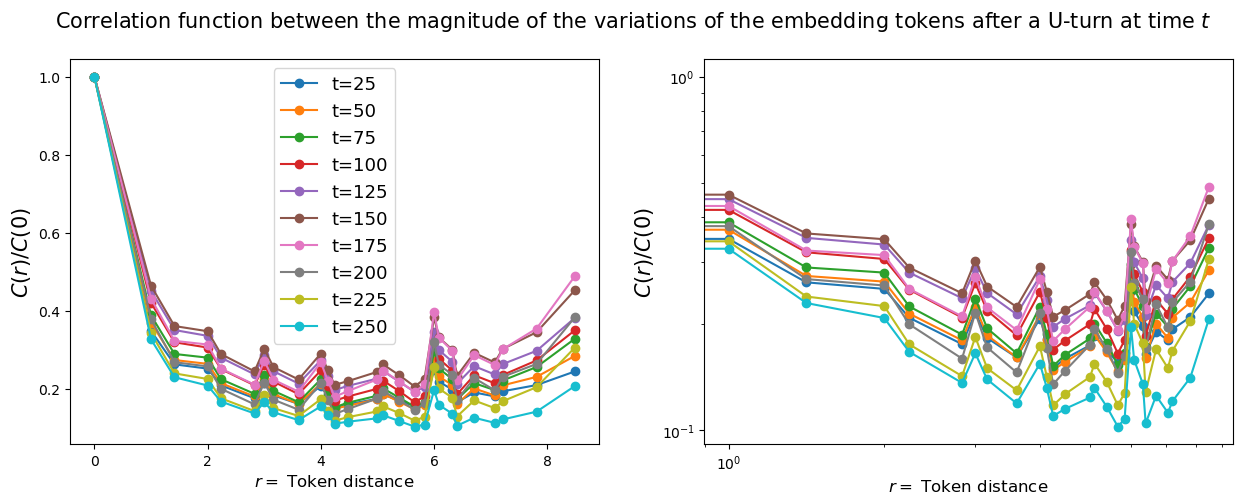

In [56]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

for key in corrfun_per_time.keys():
    axs[0].plot(dist_per_time[key], corrfun_per_time[key] / corrfun_per_time[key][0], 'o-', label=f't={key}')
    axs[1].loglog(dist_per_time[key], corrfun_per_time[key] / corrfun_per_time[key][0], 'o-', label=f't={key}')
axs[0].legend(prop={'size': 13})
axs[0].set_xlabel('$r=$ Token distance', fontsize=12)
axs[0].set_ylabel('$C(r)/C(0)$', fontsize=15)
axs[1].set_xlabel('$r=$ Token distance', fontsize=12)
axs[1].set_ylabel('$C(r)/C(0)$', fontsize=15)
#Title to the whole plot
fig.suptitle('Correlation function between the magnitude of the variations of the embedding tokens after a U-turn at time $t$', fontsize=15)
# fig.savefig(f'../../plots/clip-correlation_function.png', dpi = 300, bbox_inches='tight')
plt.show()


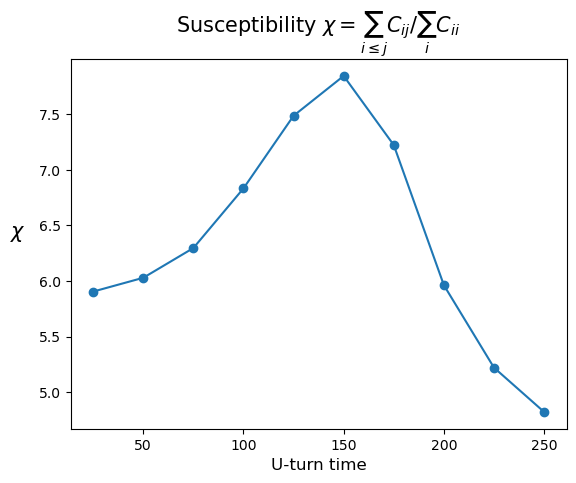

In [62]:
# chival = np.array([susceptibility_per_time[key] for key in susceptibility_per_time.keys()])
chival = np.array([susceptibility_per_time[key]/corrfun_per_time[key][0]/49 for key in susceptibility_per_time.keys()])
tvals = np.array([key for key in susceptibility_per_time.keys()])

fig, ax = plt.subplots()

ax.plot(tvals, chival, 'o-')
ax.set_xlabel('U-turn time', fontsize=12)
ax.set_ylabel('$\chi$', rotation=0, labelpad=15, fontsize=15)
ax.set_title('Susceptibility $\chi = \sum_{i\leq j}C_{ij}/\sum_{i}C_{ii}$', fontsize=15)

# chival = np.array([susceptibility_per_time[key]/49*100 for key in susceptibility_per_time.keys()])
# ax.plot(tvals, chival, 'o--')

# fig.savefig(f'../../plots/clip-susceptibility.png', dpi = 300, bbox_inches='tight')
plt.show()

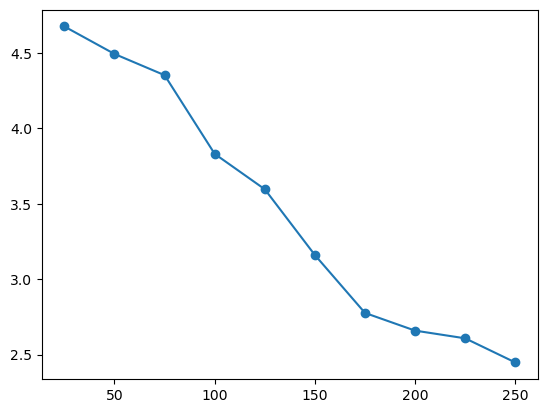

In [30]:
# chival = np.array([susceptibility_per_time[key] for key in susceptibility_per_time.keys()])
# chival = np.array([susceptibility_per_time[key]/corrfun_per_time[key][0] for key in susceptibility_per_time.keys()])
prod = [(feat_start[key] * feat_sample[key]).sum(axis=-1).mean()/512**0.5 for key in feat_start.keys()]
tvals = np.array([key for key in feat_start.keys()])

plt.plot(tvals, prod, 'o-')

In [29]:
(feat_start[key] * feat_sample[key]).sum(axis=-1).mean()/512**0.5

2.4472523755128166